# Training left vs. right classifier

This notebook contains the code to train the left vs. right classifier based on a corpus of labelled news articles.

The data comes from manual querying of many anglophone news outlets with known (i.e., already labelled) political colour.

To train the model, execute all the cells.

## 1. Load data and add labels

In [51]:
import glob
import os
import codecs
import json 

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
folderpath = '/home/hubert/Documents/kesseca/data/left_right'
filepaths = glob.glob(os.path.join(folderpath, '*.json'))

In [53]:
# Political spectrum labels
political_labels = {"Breitbart": 5,
                   "Fox News": 4,
                   "National Review": 5,
                   "The Blaze": 5,
                   "CBN News": 5,
                   "The Washington Times": 5,
                   "Townhall": 5,
                   "ABC News": 2,
                   "CBS News": 2,
                   "Daily Beast": 1,
                   "Huffington Post US": 1,
                   "The New York Times": 2,
                   "Politico": 2,
                   "Salon": 1,
                   "The Guardian": 2,
                   "Vox": 2,
                   "The Washington Post": 2,
                   "BBC.com": 3,
                   "Bloomberg": 3,
                   "CNN": 3,
                   "NPR": 3,
                   "Associated Press": 3,
                   "Reuters": 3,
                   "Wall Street Journal": 3,
                   "USA Today": 3,
                   "The Hill": 3}

In [54]:
# Load the JSON files
data = []

for path in filepaths:
    with codecs.open(path, 'r', encoding='utf8') as f:
        data.append(json.load(f))

In [55]:
file_origin = [f.split('/')[-1][:-5] for f in filepaths]

In [57]:
# Put in a simpler format
labels_political = []
labels_location = []
articles = []

for origin, outlet in zip(file_origin, data):
    for article in outlet:
        try:
            labels_political.append(political_labels[origin])
#             labels_location.append(article['location'][0]['country'])
            articles.append(article['body'])
        except:
            print('Failed: ' + origin)

/home/hubert/.pyenv/versions/3.5.1/envs/kesseca/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


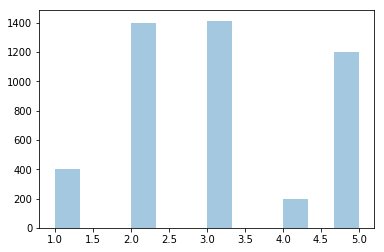

In [58]:
sns.distplot(labels_political, kde=False)

If we divide into 3 classes (left, center, right) with thresholds of < 3 and > 3, classes are pretty much balanced.

In [59]:
# Find out if there's is a difference in length
y = np.array(labels_political)
X = np.array(articles)

y_left = y[y < 3]
X_left = X[y < 3]

y_right = y[y > 3]
X_right = X[y > 3]

y_center = y[y == 3]
X_center = X[y == 3]

len_left = [len(x) for x in X_left]
len_right = [len(x) for x in X_right]
len_center = [len(x) for x in X_center]

In [10]:
print('Mean number of characters')
print('Left: {:0.1f} +/- {:0.1f}'.format(np.mean(len_left), np.std(len_left)))
print('Center: {:0.1f} +/- {:0.1f}'.format(np.mean(len_center), np.std(len_center)))
print('Right: {:0.1f} +/- {:0.1f}'.format(np.mean(len_right), np.std(len_right)))

Mean number of characters
Left: 5114.7 +/- 4221.4
Center: 3136.7 +/- 2483.4
Right: 3960.7 +/- 4441.5


Left-wing articles are longer than right-wing articles, but Center articles are the shortest of all (with the smallest standard deviation). This could be explained by the fact that many center news outlets (e.g., Reuters, Bloomberg, etc.) typically publish short, to-the-point, factual articles.

## 2. Preprocess text

In [169]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([('vect', text.CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                     ('tfidf', text.TfidfTransformer(sublinear_tf=True)),
                     ('clf', LogisticRegression(class_weight='balanced', C=100))])

In [170]:
# Just keep extreme examples
y_raw = np.array(labels_political)
y = y_raw
y[y < 3] = 0
y[y == 3] = 1
y[y > 3] = 2

In [171]:
# Remove words that shouldn't be descriptive, like news outlet names
banned_words = list(political_labels.keys())
banned_words_lower = [i.lower() for i in banned_words]
banned_words_upper = [i.upper() for i in banned_words]
banned_words = banned_words + banned_words_lower + banned_words_upper

X = []

for article in articles:
    for word in banned_words:
        article = article.replace(word, '')
    assert 'Reuters' not in article
    X.append(article)
    
X = np.array(X)

In [172]:
# Remove center for training binary classifier
ind = y != 1
y = y[ind]
X = X[ind]

In [173]:
# Find best value for C hyperparameter (then update the value above!)
from sklearn.model_selection import GridSearchCV

C_OPTIONS = [1, 10, 100, 1000]
param_grid = [{'clf__C': C_OPTIONS}]
grid = GridSearchCV(text_clf, cv=5, n_jobs=-1, param_grid=param_grid)
grid.fit(X, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores

array([0.813125, 0.829375, 0.8325  , 0.83375 ])

In [174]:
# Predict on 25% of the data to print the confusion matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True)

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

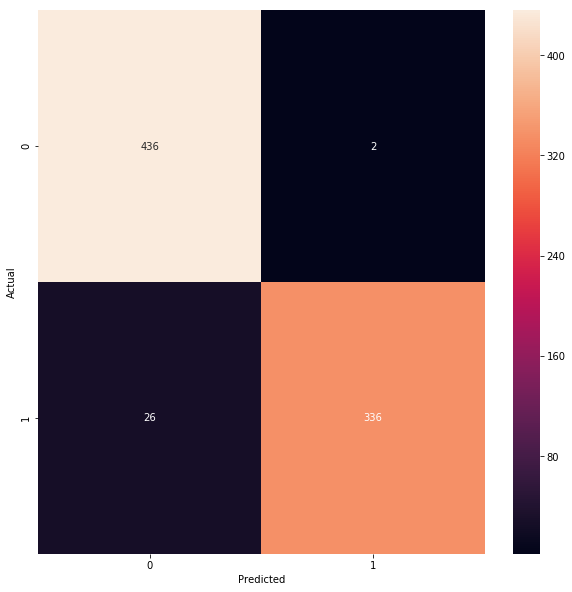

In [175]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d')
#             xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

This is not bad. Most articles are well classified into right/left-wing classes.

In [211]:
# Compute accuracy
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(text_clf, X, y, scoring='accuracy', cv=5)
np.mean(accuracies)

0.8325000000000001

In [177]:
# See what terms are used to distinguish both classes...
count_transformer = text_clf.get_params()['vect']
tfidf_transformer = text_clf.get_params()['tfidf']
clf = text_clf.get_params()['clf']

(1, 420161)

In [178]:
ind = np.argsort(clf.coef_)[0]
best_words = []

for i in np.concatenate((ind[:10], ind[-10:])):
    for key, value in count_transformer.vocabulary_.items():
        if value == i:
            best_words.append((key, clf.coef_[0, i]))

In [220]:
print('Most useful left-wing words:')
[print(i) for i in best_words[:10]];

print('\nMost useful right-wing words:')
[print(i) for i in best_words[-10:]];

Most useful left-wing words:
('mr trump', -6.381511273309706)
('mr', -5.251945317308609)
('staff', -4.432987903340318)
('sign', -4.145361039566802)
('story', -3.9514843705111655)
('official', -3.615083813726144)
('night', -3.4199985330737297)
('morning', -3.330043675085305)
('latest', -3.3097011511690906)
('mueller', -3.3040868763180042)

Most useful right-wing words:
('clinton', 4.4655503438774)
('israel', 4.517512246272596)
('comments', 4.601178462761434)
('fisa', 4.666932398218234)
('illegal immigrants', 4.678372023719681)
('disqus', 4.901217815648771)
('2018', 5.118284696352687)
('illegal', 5.8437634490352846)
('president trump', 5.970484470628693)
('com', 6.149409949326807)


## Testing on actual data - different versions of the same news

This data was fetched using the Kesseca pipeline - it consists in one translated Radio-Canada article, and of several other articles on the same topic found by the pipeline.

In [181]:
rc_path = '/home/hubert/Documents/kesseca/data/five_articles/trump_firearm/rc.json'
outlet_path = '/home/hubert/Documents/kesseca/data/five_articles/trump_firearm/outlets.json'

# Load the files
with codecs.open(rc_path, 'r', encoding='utf8') as f:
    rc_text = f.read()
    
with codecs.open(outlet_path, 'r', encoding='utf8') as f:
    outlet_text = json.load(f)
    
outlet_text['Radio-Canada'] = rc_text

In [223]:
labels = []
values = []
for key, value in outlet_text.items():
    labels.append(key)
    values.append(value)
    
y_pred = text_clf.predict_proba(values)

print('Outlet - P(right-wing)')
print('======================')
[print(i, '-', j[1]) for i, j in zip(labels, y_pred)];

Outlet - P(right-wing)
Politico - EU - 0.05676594126396215
Huffington Post US - 0.11142206642495787
USA Today - 0.07747680897054683
Wall Street Journal - 0.042862904949519325
Breitbart - 0.7137867738008166
Townhall - 0.9535619890315651
The Guardian - 0.06533627548549643
The Blaze - 0.38986101222865976
Daily Beast - 0.8028172470721607
The New York Times - 0.1482541547673449
Fox News - 0.8633440664569921
The Washington Post - 0.1544099276204683
Salon - 0.1182231854736531
CNN - 0.22255902542250272
Radio-Canada - 0.018787386183719442
Vox - 0.7741475446300728
Associated Press - 0.3066640079732325
ABC News Australia - 0.039707012427628946
CBN News - 0.4795945163477292
The Hill - 0.11419557817387108
Reuters - 0.2143615816076542
Bloomberg - 0.1415275372678159
ABC News - 0.09267507610392493


## Save model and make it a function

In [194]:
# Save pipeline model to disk
from sklearn.externals import joblib

joblib.dump(text_clf, 'left_right_clf.pkl') 

['left_right_clf.pkl']

In [209]:
from sklearn.externals import joblib

def classify_left_right(article, clf=None):
    """Classify an article as being left-wing or right-wing.
    
    Args:
        article (str or list of str): body of the article(s)
        
    Keyword Args:
        clf (sklearn.Pipeline): pipeline object containing the 
            classification pipeline to run on the text. If not
            provided, will attempt to load automatically from the
            same directory.
        
    Returns:
        (float): probability of the article having a right-wing
            bias
    """
    if clf is None:
        clf = joblib.load('left_right_clf.pkl')
    
    if isinstance(article, str):
        article = [article]
    
    y_pred = clf.predict_proba(article)[:, 1]
    
    return y_pred

In [210]:
clf = joblib.load('left_right_clf.pkl')

classify_left_right(outlet_text['Radio-Canada'], clf=clf)

array([0.01878739])